<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2025/Wavelet_stationnary_transitoires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stationnary Wavelet denoising applied to transient a signal (1D)

Use PyWavelets library.

In [1]:
import numpy as np
from  scipy import signal
from sklearn.preprocessing import MinMaxScaler


In [2]:
!pip install -U PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.3 MB/s eta 0:00:00


In [3]:
# PyWavelets
import pywt

In [4]:
rng = np.random.default_rng(42)  # init random for repetability

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

# The signal

In [6]:
def h0(x):
  return 10*np.sin(4*np.pi*x+0.8*np.pi)
def h1(x):
  return 5*(2*x)**3-100
def f0(x):
 return np.piecewise(x,
                     [x<=0.2,
                      (0.2<x) & (x<=0.4),
                     (0.4<x) & (x<=1.1),
                     (1.1<x) & (x<=1.4),
                      (1.4<x) & (x<= 1.5),
                      (1.5<x) & (x<=1.8),
                     x>=1.8],
                     [0.,
                      -30.,
                      lambda x:h0(x),
                      lambda x:h1(x),
                      lambda x:h1(x)+30,
                      lambda x:h1(x)-30,
                      0.
                     ])


def f(x):
  return -f0(2*x)/10.

In [7]:
Ns = 2**10 # number of samples   MUST BE A power of 2

In [8]:
time =np.arange(0., 1.0, 1./Ns)
y = f(time)

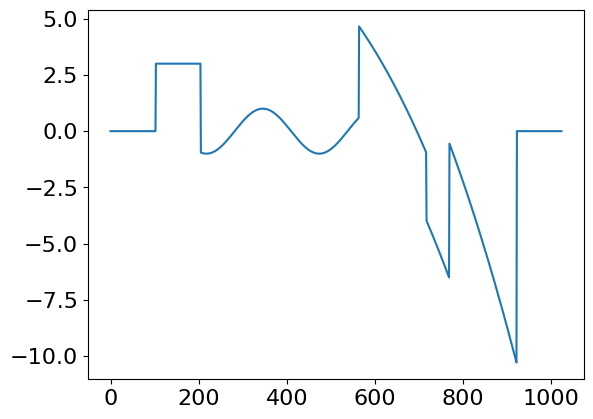

In [9]:
plt.plot(y);

In [69]:
# this formulation of sigma_corrupt is just to compare with other codes
noise_power = 0.01 * Ns / 2
# next: factor 0.1 useful to reproduce results similar to fig. 11.4 WaveleTour
#       factor 0.2 to comapre to over nb Wiener & Wavelet standard
sigma_corrupt = 0.2 * np.sqrt(noise_power)
noise = rng.normal(scale=sigma_corrupt, size=time.shape)   # noise corruption

In [62]:
y_noisy = y + noise  # noisy signal

In [63]:
def snr(sig,ref):
  """ Signal to noise ratio in dB
      sig: noisy signal
      ref: clean signal (reference)
  """
  a = np.nanmean(ref**2)
  c = np.nanmean((sig-ref)**2)
  return 10*np.log10(a/c)

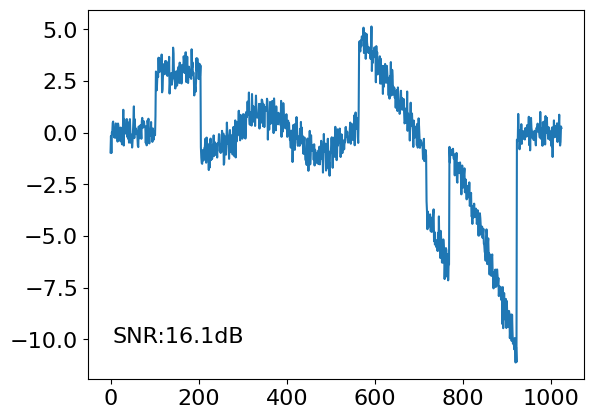

In [64]:
plt.plot(y_noisy);
ax=plt.gca()
plt.text(0.05,0.1,f"SNR:{snr(y_noisy,y):.1f}dB",backgroundcolor="white",transform=ax.transAxes);

# Denoising

In [65]:
def Energy(x):
  return np.dot(x, x)


def mad(x):
  """! Estimates the Median Absolute Deviation (MAD). MAD is defined to be
  the median of the absolute difference between the input X and median(X).
  """
  return 1.482579 * np.median(np.abs(x - np.median(x)))


def UniversalThreshold(signal, sigma=None):
  """! Universal threshold  Donoho & Johnstone
  """
  m = signal.shape[0]
  if sigma is None:
    sd = mad(signal)
  else:
    sd = sigma
  thr = sd * np.sqrt(2 * np.log(m))
  return thr

def SteinThreshold(signal):
  """! An implementation of Stein's unbiased rist estimator (SURE)
  inspired by Mathematica
  """
  m = signal.shape[0]
  sorted_signal = np.sort(signal**2)
  c = np.linspace(m-1, 0, m)
  s = np.cumsum(sorted_signal) + c * sorted_signal
  risk = (m - (2.0 * np.arange(m)) + s)
  ibest = np.argmin(risk)
  thr = np.sqrt(sorted_signal[ibest])
  return thr

def Thresh_hard_sparse(x, k, return_ind=False):
    """
    Keep only k largest entries of x and return their indices.
    Parameters
    """
    _x = x.copy()
    ind = np.argpartition(abs(_x), -k, axis=None)[-k:]
    ind = np.unravel_index(ind, _x.shape)
    ind_del = np.ones(_x.shape, dtype=bool)
    ind_del[ind] = False
    _x[ind_del] = 0
    if return_ind:
      return _x, ind
    else:
      return _x


class Denoising:
    """! Denoising class
    normalize : True, [False]  to preprocess th signal before denoising
    wavelet: name of wavelet (pywt.wavelist(kind='discrete'))
    level: up to which level to apply wavelet decomposition, 0 is max
    thr_mode: type of threshold [hard]/soft
    thr_lbl :if True means thr defined for each level
    pad_mode: print(pywt.Modes.modes)
    coeff_perc: for k-highest method fraction of highest total coeff kept
    sigma_univ: for debuging purpose (see code if interest)
    """
    def __init__(self,
                 normalize=False,
                 wavelet='haar',
                 level=1,
                 thr_mode='hard',
                 thr_lbl= True,
                 pad_mode='zero',
                 method='universal',
                 coeff_perc=0.05,
                 sigma_univ=None,
                 fact_univ=1.0
                 ):

        self.normalize = normalize
        self.wavelet = wavelet
        self.level = level
        self.method = method
        self.thr_mode = thr_mode
        self.thr_lbl = thr_lbl
        self.pad_mode = pad_mode
        self.coeff_perc  = coeff_perc  #  for k-highest method

        #for univerval thr
        self.sigma_univ = sigma_univ
        self.fact_univ = fact_univ

        self.filter_ = pywt.Wavelet(self.wavelet)    # Wavelet function

        # Check if level is None and set it to 1
        if level is None:
            self.nlevel = 1
        else:
            self.nlevel = level

    def fit(self, signal):
      """
      denoising processing
      """
      _signal = signal.copy()

      # normalise
      if self.normalize:
          self.scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
          _signal = self.scaler.fit_transform(_signal.reshape(-1, 1))[:, 0]

      # decomposition
      if self.nlevel == 0:
          level = pywt.dwt_max_level(_signal.shape[0],
                                  filter_len=self.filter_.dec_len)
          self.nlevel = level

      norm_swt=True
      coeffs = pywt.swt(_signal, self.filter_, level=self.nlevel,
                        trim_approx=True, norm=norm_swt)

      # thresholding
      if self.thr_lbl:
        # compute threshold at all levels of details and apply accordingly
        thr = [self.DetermineThreshold(coeffs[1+level], self.sigma_univ)
                         for level in range(self.nlevel)]
        coeffs[1:] = [pywt.threshold(c, value=thr[i], mode=self.thr_mode)
                      for i, c in enumerate(coeffs[1:])]
      else:
        if self.method == 'k-highest':
          # special for method which keeps a fraction of the total amount
          # of coefficients (approx & refinements)
          coeff_vec, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs)
          n_coeffs =int(self.coeff_perc * len(coeff_vec))
          coeff_k = Thresh_hard_sparse(coeff_vec, n_coeffs)
          coeffs = pywt.unravel_coeffs(coeff_k, coeff_slices,
                                       coeff_shapes, output_format='wavedec')
        elif self.method == 'universal':
          # compute threshold with detail coefficients at first refinement
          # the length to be considered is the signal length
          thr = self.DetermineThreshold(coeffs[1],self.sigma_univ)\
                      * np.sqrt(np.log(len(_signal))/np.log(len(coeffs[1])))
          #print("thr",thr)
          coeffs[1:] = [pywt.threshold(c, value=thr*self.fact_univ, mode=self.thr_mode)
                      for i, c in enumerate(coeffs[1:])]
        else:
          # compute threshold with detail coefficients at first refinement
          #print("taill D1:",len(coeffs[1]))
          thr = self.DetermineThreshold(coeffs[1], self.sigma_univ)
          #print("thr",thr)
          # apply at all levels of details
          coeffs[1:] = [pywt.threshold(c, value=thr, mode=self.thr_mode)
                      for i, c in enumerate(coeffs[1:])]

      # filter
      denoised_signal = pywt.iswt(coeffs, self.filter_, norm=norm_swt)

      # Inverse normalization in case the input signal was normalized
      if self.normalize:
          denoised_signal = self.scaler.inverse_transform(
                    denoised_signal.reshape(-1, 1))[:, 0]

      return denoised_signal,  self.nlevel

    def DetermineThreshold(self, coeff, sigma_univ=None):
        """! Determines the value of the threshold.
        - for some threshold applyied to all levels see the code of "fit"
        - 'universal' - The threshold is the sqrt(2*length(x))*mad
        - 'stein' - Stein's unbiased risk estimator
        - 'energy' - Computes the energy of the coefficients and retains a
        predefined percentage of it.

        default method is the 'universal' method.
        """
        thr = 0.0
        if self.method == 'universal':
            thr = UniversalThreshold(coeff, sigma_univ)
        elif self.method == 'stein':
            thr = SteinThreshold(coeff)
        else:
            print("No such method detected!")
            print("Set back to default (universal thresholding)!")
            thr = UniversalThreshold(coeff)
        return thr


In [66]:
#pywt.wavelist(kind='discrete')

# What is the setting to get the best SNR?

In [67]:


thr_modes=['hard',None,'soft', 'hard', 'soft', 'hard', 'soft', 'soft']
methods=['universal','k-highest', 'universal', 'universal','universal','stein', 'stein','stein']
thr_lbls=[False,False,False,True,True,True,True,False]
coeff_percs=[1.0,0.095,1.0,1.0,1.0,1.0,1.0,1.0]

best_snr=-1
best_filtered=None
best_method=None
for wave_name in ["db2",'db4','sym2','sym4']:
  for level_max in [0,4]:
    for i in range(len(methods)):
      wd = Denoising(normalize=False,
                wavelet=wave_name,
                level=level_max,
                thr_mode=thr_modes[i],
                method=methods[i],
                thr_lbl = thr_lbls[i],
                coeff_perc=coeff_percs[i],
                )

      y_filtered, lvl_max  = wd.fit(y_noisy)
      snr_cur = snr(y_filtered,y)
      if snr_cur>best_snr:
        best_snr=snr_cur
        best_filtered = y_filtered
        best_method = wave_name+ ":" + methods[i]
        if thr_modes[i] is not None:
          best_method += "/"+thr_modes[i]+"/"
        if thr_lbls[i]:
          best_method += "lv by lv"
        else:
          best_method += "all lv"
        best_method += f" lvl_max:{lvl_max}"

      print(wave_name,methods[i],"----" if thr_modes[i] is None else thr_modes[i],",lv by lv," if thr_lbls[i]  else ",  all lv,",
          f"({lvl_max})",f"SNR:{snr_cur:.2f}")

db2 universal hard ,  all lv, (8) SNR:3.11
db2 k-highest ---- ,  all lv, (8) SNR:7.95
db2 universal soft ,  all lv, (8) SNR:3.11
db2 universal hard ,lv by lv, (8) SNR:4.74
db2 universal soft ,lv by lv, (8) SNR:4.01
db2 stein hard ,lv by lv, (8) SNR:9.46
db2 stein soft ,lv by lv, (8) SNR:6.49
db2 stein soft ,  all lv, (8) SNR:12.72
db2 universal hard ,  all lv, (4) SNR:21.96
db2 k-highest ---- ,  all lv, (4) SNR:15.60
db2 universal soft ,  all lv, (4) SNR:21.40
db2 universal hard ,lv by lv, (4) SNR:24.94
db2 universal soft ,lv by lv, (4) SNR:20.33
db2 stein hard ,lv by lv, (4) SNR:20.43
db2 stein soft ,lv by lv, (4) SNR:17.40
db2 stein soft ,  all lv, (4) SNR:17.47
db4 universal hard ,  all lv, (7) SNR:4.93
db4 k-highest ---- ,  all lv, (7) SNR:9.02
db4 universal soft ,  all lv, (7) SNR:4.93
db4 universal hard ,lv by lv, (7) SNR:6.54
db4 universal soft ,lv by lv, (7) SNR:5.71
db4 stein hard ,lv by lv, (7) SNR:13.21
db4 stein soft ,lv by lv, (7) SNR:7.94
db4 stein soft ,  all lv, (7) SNR

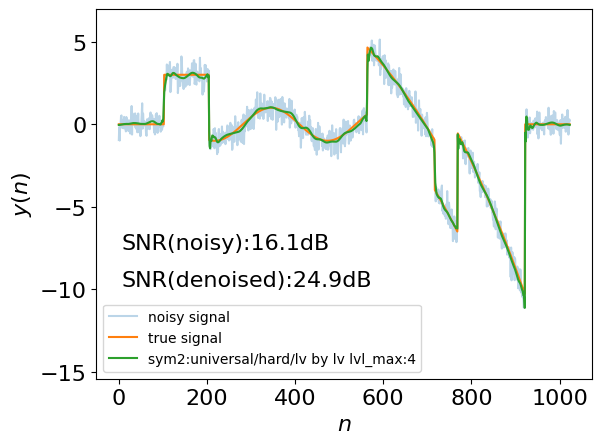

In [68]:
plt.plot(y_noisy,alpha=0.3, label="noisy signal")
plt.plot(y,label="true signal")
plt.plot(best_filtered,label=best_method)
plt.xlabel(r"$n$")
plt.ylabel(r"$y(n)$");
ax = plt.gca()
plt.text(0.05,0.35,f"SNR(noisy):{snr(y_noisy,y):.1f}dB",backgroundcolor="white", transform=ax.transAxes)
plt.text(0.05,0.25,f"SNR(denoised):{best_snr:.1f}dB",backgroundcolor="white",transform=ax.transAxes)
plt.ylim([y.min()*1.5,y.max()*1.5])
plt.legend(fontsize=10,loc='lower left');